Copyright **`(c)`** 2023 Andrea Galella s310166

`<andrea.galella@studenti.polito.it>` or `<galella.andrea@gmail.com>`

[`https://github.com/andrea-ga/computational-intelligence`](https://github.com/andrea-ga/computational-intelligence)

References - Course repository:  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)

Free for personal or classroom use; see [`LICENSE.md`](https://github.com/andrea-ga/computational-intelligence/blob/main/LICENSE.md) for details.

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [2]:
from random import choices, choice, randint, random, shuffle, sample
from dataclasses import dataclass
from copy import copy
from typing import List

import lab9_lib
import matplotlib.pyplot as plt

In [3]:
GENOME_LENGTH = 1000

@dataclass
class Individual:
    fitness: float
    genotype: list[int]

def populate(fitness, pop_size):
    population = [
        Individual(
            genotype=[choice((0,1)) for _ in range(GENOME_LENGTH)],
            fitness=None,
        )
        for _ in range(pop_size)
    ]

    for i in population:
        i.fitness = fitness(i.genotype)

    return population

def select_parent(pop, tour_size): #TOURNAMENT SELECTION
    pool = [choice(pop) for _ in range(tour_size)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

def flip_mutation(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos = randint(0, GENOME_LENGTH-1)
    offspring.genotype[pos] = 1 - offspring.genotype[pos]
    offspring.fitness = None
    return offspring

def swap_mutation(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos1, pos2 = sample(range(GENOME_LENGTH), 2)

    tmp = offspring.genotype[pos1]
    offspring.genotype[pos1] = offspring.genotype[pos2]
    offspring.genotype[pos2] = tmp

    offspring.fitness = None
    return offspring

def scramble_mutation(ind: Individual) -> Individual:
    offspring = copy(ind)

    start, end = sorted(sample(range(GENOME_LENGTH), 2))
            
    subset = offspring.genotype[start:end]
    shuffle(subset)
    offspring.genotype[start:end] = subset
    
    offspring.fitness = None
    return offspring

def inversion_mutation(ind: Individual) -> Individual:
    offspring = copy(ind)

    start, end = sorted(sample(range(GENOME_LENGTH), 2))
            
    subset = offspring.genotype[start:end]
    offspring.genotype[start:end] = subset[::-1]
    
    offspring.fitness = None
    return offspring

def one_cut_xover(ind1: Individual, ind2: Individual) -> List[Individual]:
    cut_point = randint(0, GENOME_LENGTH-1)
    offspring1 = Individual(fitness=None,
                           genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
    offspring2 = Individual(fitness=None,
                           genotype=ind2.genotype[:cut_point] + ind1.genotype[cut_point:])
    assert len(offspring1.genotype) == GENOME_LENGTH and len(offspring2.genotype) == GENOME_LENGTH
    return [offspring1, offspring2]

def two_cut_xover(ind1: Individual, ind2: Individual) -> List[Individual]:
    cut_points = sample(range(GENOME_LENGTH), 2)
    cut_points.sort()
    
    list1 = ind1.genotype[:cut_points[0]] + ind2.genotype[cut_points[0]:cut_points[1]] + ind1.genotype[cut_points[1]:]
    list2 = ind2.genotype[:cut_points[0]] + ind1.genotype[cut_points[0]:cut_points[1]] + ind2.genotype[cut_points[1]:]

    offspring1 = Individual(fitness=None,
                           genotype=list1)
    offspring2 = Individual(fitness=None,
                           genotype=list2)
    assert len(offspring1.genotype) == GENOME_LENGTH and len(offspring2.genotype) == GENOME_LENGTH
    return [offspring1, offspring2]

def uniform_xover(ind1: Individual, ind2: Individual) -> List[Individual]:
    list1 = [0 for _ in range(GENOME_LENGTH)]
    list2 = [0 for _ in range(GENOME_LENGTH)]

    for i in range(GENOME_LENGTH):
        if random() < 0.5:
            list1[i] = ind1.genotype[i]
            list2[i] = ind2.genotype[i]
        else:
            list1[i] = ind2.genotype[i]
            list2[i] = ind1.genotype[i]

    offspring1 = Individual(fitness=None,
                           genotype=list1)
    offspring2 = Individual(fitness=None,
                           genotype=list2)
    assert len(offspring1.genotype) == GENOME_LENGTH and len(offspring2.genotype) == GENOME_LENGTH
    return [offspring1, offspring2]

In [4]:
def hamming_distance(population):
    total_distance = 0
    num_comp = 0

    #I COMPARE EACH INDIVIDUAL WITH THE NEXT ONE
    for i in range(len(population)):
        for j in range(i+1, len(population)):
            total_distance += sum([x ^ y for x,y in zip(population[i].genotype, population[j].genotype)]) #number of different bits
            num_comp += 1

    return total_distance/num_comp

#ALTERNATIVES

def hamming_distance2(population):
    total_distance = 0
    num_comp = 0

    for i in range(len(population)):
        for j in range(i+1, len(population)):
            total_distance += population[i].fitness - population[j].fitness #fitness difference
            num_comp += 1

    return total_distance/num_comp

## EA

In [5]:
def ea(fitness, population, num_epochs, num_generations, pop_size, off_size, tour_size, mut_prob, xover_prob, adapt_mut, elitism):
    best = max(population, key=lambda i:i.fitness)
    history = [] #HISTORY OF BEST SOLUTION FOR EACH GENERATION
    calls_history = [] #HISTORY OF NUMBER OF CALLS FOR EACH GENERATION
    mut_choice_prob = [0.1, 0.2, 0.3, 0.4] #PROBABILITY LIST WHERE EACH VALUE IS LINKED TO A MUTATION ALGORITHM

    for epoch in range(num_epochs):
        if best.fitness == 1: #IF THE MAX VALUE OF FITNESS IS REACHED, I BREAK
            break
        
        if adapt_mut:
            #IF THE ACTUAL POPULATION HAS SMALL GENOTYPE DIVERSITY, I INCREASE THE MUTATION PROBABILITY FOR EXPLORATION
            hd = hamming_distance(population)
            if hd < 100 and mut_prob <= 0.95:
                mut_prob += 0.05
            elif hd > 800 and mut_prob >= 0.05:
                mut_prob -= 0.05
        
        for generation in range(num_generations): #NEW GENERATION
            if best.fitness == 1: #IF THE MAX VALUE OF FITNESS IS REACHED, I BREAK
                break

            offspring = list()
            for counter in range(off_size): #OFFSPRING GENERATION
                if random() < xover_prob:
                    xover = choice([one_cut_xover, two_cut_xover, uniform_xover]) #RANDOMLY CHOOSE A CROSSOVER ALGORITHM

                    p1 = select_parent(population, tour_size)
                    p2 = select_parent(population, tour_size)
                    off = xover(p1, p2)

                    for o in off:
                        if random() < mut_prob:
                            mutation = choices([flip_mutation, inversion_mutation, swap_mutation, scramble_mutation], mut_choice_prob, k=1)[0] #CHOOSE MUTATION ALGORITHM
                            o = mutation(o)

                    for o in off:
                        offspring.append(o)

            for i in offspring:
                i.fitness = fitness(i.genotype)

            population.extend(offspring)

            if elitism:
                population.sort(key=lambda i: i.fitness, reverse=True)
                population = population[:pop_size]

                best = population[0]
            else:
                for p in population:
                    if p.fitness > best.fitness:
                        best = p

                population = choices(population, k=pop_size)
                  
            history.append(best.fitness)
            calls_history.append(fitness.calls)

        if epoch >= 1 and history[len(history) - num_generations] == best.fitness: #IF THERE'S NO IMPROVEMENT IN FITNESS FOR 1 EPOCH, I SHUFFLE THE MUTATION CHOICE PROBABILITIES
            if epoch >= 2 and history[len(history) - num_generations*2] == best.fitness: #IF THERE'S NO IMPROVEMENT IN FITNESS FOR 2 SUCCESSIVE EPOCHS, I BREAK FOR COMPUTATIONAL TIME REASONS
                break

            shuffled_indices = list(range(len(mut_choice_prob)))
            shuffle(shuffled_indices)
            mut_choice_prob = [mut_choice_prob[i] for i in shuffled_indices]

    return (best, fitness.calls, history, calls_history)

## 1

### Single Run

BEST FITNESS: 1.0, CALLS: 14148


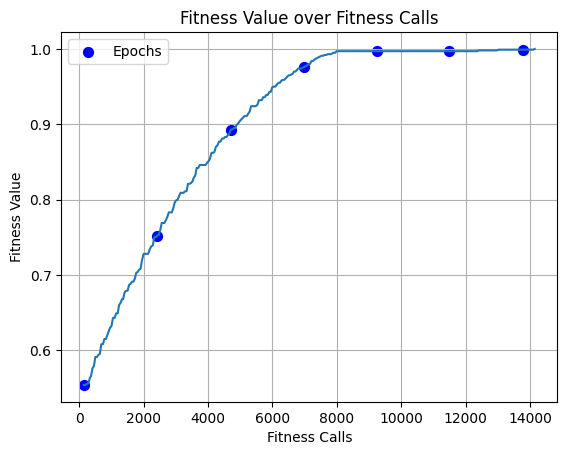

In [66]:
fitness = lab9_lib.make_problem(1)
num_epochs = 20
num_generations = 50
population_size = 100
offset_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05

best, calls, history, calls_history = ea(fitness, population, num_epochs, num_generations, pop_size=population_size,
                  off_size=offset_size, tour_size=2, mut_prob=mutation_probability, xover_prob=0.9, elitism=True, adapt_mut=True)

print(f"BEST FITNESS: {best.fitness}, CALLS: {calls}")
plt.plot(calls_history, history)
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(calls_history)) if i%num_generations == 0]
highlighted_calls = [calls_history[i] for i in best_index_list]
highlighted_values = [history[i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

### Overall

BEST FIT
(FITNESS: 1.0, NUM CALLS: 8342, NUM EPOCHS: 50, NUM GENERATIONS: 50, TOURNAMENT SIZE: 3, ADAPTIVE MUTATION: True, ELITISM: True)


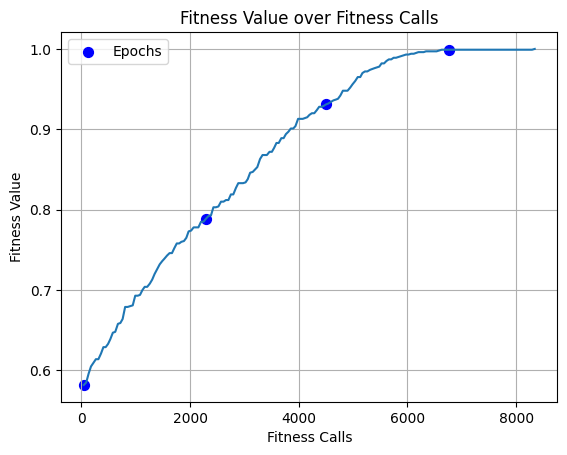

BEST NUM CALLS
(FITNESS: 0.997, NUM CALLS: 8116, NUM EPOCHS: 50, NUM GENERATIONS: 20, TOURNAMENT SIZE: 3, ADAPTIVE MUTATION: True, ELITISM: True)


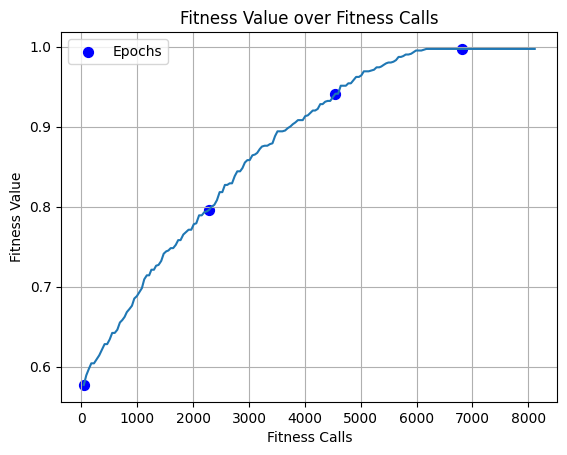

BEST AVERAGE (FIT and NUM CALLS)
(FITNESS: 0.997, NUM CALLS: 8116, NUM EPOCHS: 50, NUM GENERATIONS: 20, TOURNAMENT SIZE: 3, ADAPTIVE MUTATION: True, ELITISM: True)


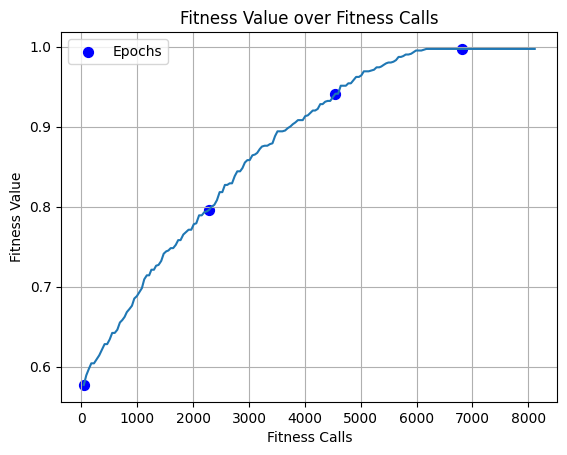

In [67]:
fitness = lab9_lib.make_problem(1)
population_size = 100
offspring_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05
xover_probability = 0.9

num_epochs = [20, 50]
num_generations = [20, 50]
tour_sizes = [2, 3]
elitism = [True, False]
adapt_mut = [True, False]

prev_calls = 0 #USED TO NORMALIZE THE NUMBER OF FUNCTION CALLS FOR EACH ITERATION
results = []
best_fit = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST FITNESS
best_calls = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST NUMBER OF CALLS
best_avg = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST AVERAGE RESULT

for ne in num_epochs:
    for ng in num_generations:
        for t in tour_sizes:
            for e in elitism:
                for a in adapt_mut:
                    best, calls, history, calls_history = ea(fitness, population, num_epochs=ne, num_generations=ng, pop_size=population_size,
                                                            off_size=offspring_size, tour_size=t, mut_prob=mutation_probability,
                                                            xover_prob=xover_probability, adapt_mut=a, elitism=e)
                    
                    norm_calls_history = [x-prev_calls for x in calls_history] #normalized calls_history list
                    results.append([best, calls-prev_calls, ne, ng, t, a, e, history, norm_calls_history])
                    prev_calls = calls

res_fit = [r[0].fitness for r in results]
res_calls = [r[1] for r in results]
avg_fit = sum(res_fit) / len(res_fit)
avg_calls = sum(res_calls) / len(res_calls)

for r in results:
    if not best_fit or r[0].fitness > best_fit[0].fitness or (r[0].fitness == best_fit[0].fitness and r[1] < best_fit[1]):
        best_fit = r
    
    if not best_calls or r[1] < best_calls[1] or (r[1] == best_calls[1] and r[0].fitness > best_fit[0].fitness):
        best_calls = r

    if r[0].fitness >= avg_fit and r[1] <= avg_calls:
        if not best_avg:
            best_avg = r
        else:
            if (r[0].fitness > best_avg[0].fitness and r[1] < best_avg[1]) or (r[0].fitness <= best_avg[0].fitness and r[1] < best_avg[1]):
                best_avg = r

#PLOTTING
print("BEST FIT")
print(f"(FITNESS: {best_fit[0].fitness}, NUM CALLS: {best_fit[1]}, NUM EPOCHS: {best_fit[2]}, NUM GENERATIONS: {best_fit[3]}, TOURNAMENT SIZE: {best_fit[4]}, ADAPTIVE MUTATION: {best_fit[5]}, ELITISM: {best_fit[6]})")
plt.plot(best_fit[8], best_fit[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_fit[7])) if i%ng == 0]
highlighted_calls = [best_fit[8][i] for i in best_index_list]
highlighted_values = [best_fit[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

print("BEST NUM CALLS")
print(f"(FITNESS: {best_calls[0].fitness}, NUM CALLS: {best_calls[1]}, NUM EPOCHS: {best_calls[2]}, NUM GENERATIONS: {best_calls[3]}, TOURNAMENT SIZE: {best_calls[4]}, ADAPTIVE MUTATION: {best_calls[5]}, ELITISM: {best_calls[6]})")
plt.plot(best_calls[8], best_calls[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_calls[7])) if i%ng == 0]
highlighted_calls = [best_calls[8][i] for i in best_index_list]
highlighted_values = [best_calls[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

if best_avg:
    print("BEST AVERAGE (FIT and NUM CALLS)")
    print(f"(FITNESS: {best_avg[0].fitness}, NUM CALLS: {best_avg[1]}, NUM EPOCHS: {best_avg[2]}, NUM GENERATIONS: {best_avg[3]}, TOURNAMENT SIZE: {best_avg[4]}, ADAPTIVE MUTATION: {best_avg[5]}, ELITISM: {best_avg[6]})")
    plt.plot(best_avg[8], best_avg[7])
    plt.title("Fitness Value over Fitness Calls")
    plt.xlabel("Fitness Calls")
    plt.ylabel("Fitness Value")
    plt.grid(True)
    best_index_list = [i for i in range(len(best_avg[7])) if i%ng == 0]
    highlighted_calls = [best_avg[8][i] for i in best_index_list]
    highlighted_values = [best_avg[7][i] for i in best_index_list]
    plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
    plt.legend()
    plt.show()

## 2

### Single Run

BEST FITNESS: 0.982, CALLS: 45110


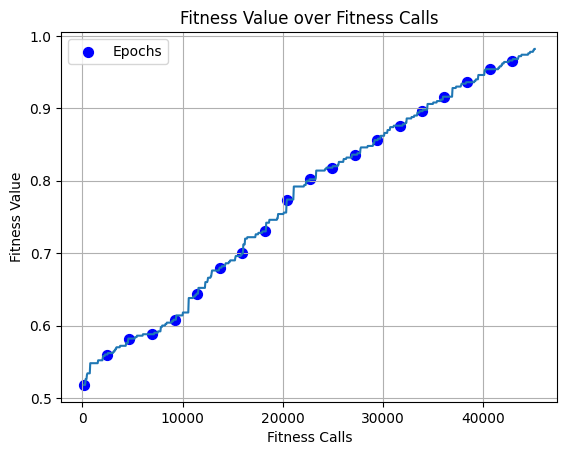

In [68]:
fitness = lab9_lib.make_problem(2)
num_epochs = 20
num_generations = 50
population_size = 100
offset_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05

best, calls, history, calls_history = ea(fitness, population, num_epochs, num_generations, pop_size=population_size,
                  off_size=offset_size, tour_size=2, mut_prob=mutation_probability, xover_prob=0.9, elitism=True, adapt_mut=True)

print(f"BEST FITNESS: {best.fitness}, CALLS: {calls}")
plt.plot(calls_history, history)
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(calls_history)) if i%num_generations == 0]
highlighted_calls = [calls_history[i] for i in best_index_list]
highlighted_values = [history[i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

### Overall

BEST FIT
(FITNESS: 1.0, NUM CALLS: 41312, NUM EPOCHS: 50, NUM GENERATIONS: 50, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: True, ELITISM: True)


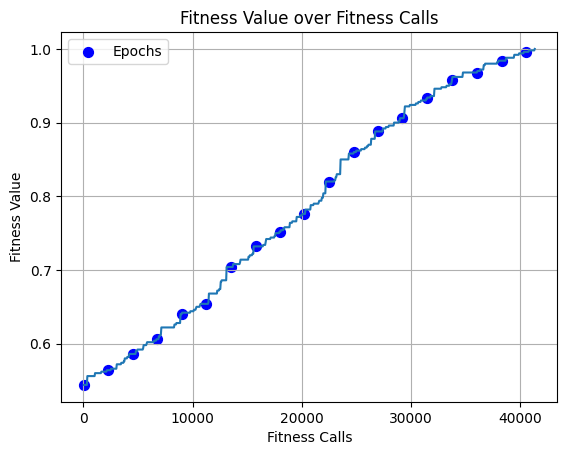

BEST NUM CALLS
(FITNESS: 0.544, NUM CALLS: 2636, NUM EPOCHS: 50, NUM GENERATIONS: 20, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: False, ELITISM: False)


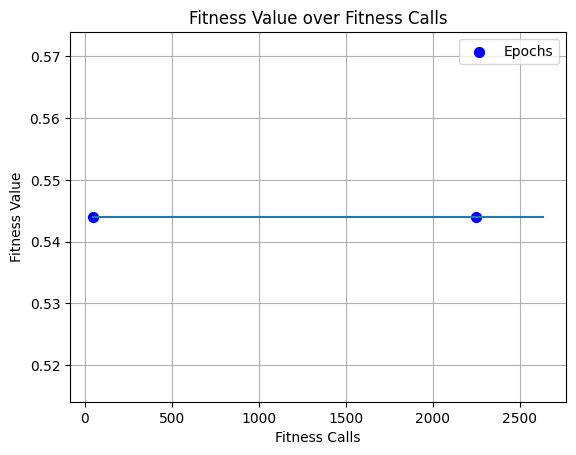

In [69]:
fitness = lab9_lib.make_problem(2)
population_size = 100
offspring_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05
xover_probability = 0.9

num_epochs = [20, 50]
num_generations = [20, 50]
tour_sizes = [2, 3]
elitism = [True, False]
adapt_mut = [True, False]

prev_calls = 0 #USED TO NORMALIZE THE NUMBER OF FUNCTION CALLS FOR EACH ITERATION
results = []
best_fit = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST FITNESS
best_calls = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST NUMBER OF CALLS
best_avg = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST AVERAGE RESULT

for ne in num_epochs:
    for ng in num_generations:
        for t in tour_sizes:
            for e in elitism:
                for a in adapt_mut:
                    best, calls, history, calls_history = ea(fitness, population, num_epochs=ne, num_generations=ng, pop_size=population_size,
                                                            off_size=offspring_size, tour_size=t, mut_prob=mutation_probability,
                                                            xover_prob=xover_probability, adapt_mut=a, elitism=e)
                    
                    norm_calls_history = [x-prev_calls for x in calls_history] #normalized calls_history list
                    results.append([best, calls-prev_calls, ne, ng, t, a, e, history, norm_calls_history])
                    prev_calls = calls

res_fit = [r[0].fitness for r in results]
res_calls = [r[1] for r in results]
avg_fit = sum(res_fit) / len(res_fit)
avg_calls = sum(res_calls) / len(res_calls)

for r in results:
    if not best_fit or r[0].fitness > best_fit[0].fitness or (r[0].fitness == best_fit[0].fitness and r[1] < best_fit[1]):
        best_fit = r
    
    if not best_calls or r[1] < best_calls[1] or (r[1] == best_calls[1] and r[0].fitness > best_fit[0].fitness):
        best_calls = r

    if r[0].fitness >= avg_fit and r[1] <= avg_calls:
        if not best_avg:
            best_avg = r
        else:
            if (r[0].fitness > best_avg[0].fitness and r[1] < best_avg[1]) or (r[0].fitness <= best_avg[0].fitness and r[1] < best_avg[1]):
                best_avg = r

#PLOTTING
print("BEST FIT")
print(f"(FITNESS: {best_fit[0].fitness}, NUM CALLS: {best_fit[1]}, NUM EPOCHS: {best_fit[2]}, NUM GENERATIONS: {best_fit[3]}, TOURNAMENT SIZE: {best_fit[4]}, ADAPTIVE MUTATION: {best_fit[5]}, ELITISM: {best_fit[6]})")
plt.plot(best_fit[8], best_fit[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_fit[7])) if i%ng == 0]
highlighted_calls = [best_fit[8][i] for i in best_index_list]
highlighted_values = [best_fit[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

print("BEST NUM CALLS")
print(f"(FITNESS: {best_calls[0].fitness}, NUM CALLS: {best_calls[1]}, NUM EPOCHS: {best_calls[2]}, NUM GENERATIONS: {best_calls[3]}, TOURNAMENT SIZE: {best_calls[4]}, ADAPTIVE MUTATION: {best_calls[5]}, ELITISM: {best_calls[6]})")
plt.plot(best_calls[8], best_calls[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_calls[7])) if i%ng == 0]
highlighted_calls = [best_calls[8][i] for i in best_index_list]
highlighted_values = [best_calls[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

if best_avg:
    print("BEST AVERAGE (FIT and NUM CALLS)")
    print(f"(FITNESS: {best_avg[0].fitness}, NUM CALLS: {best_avg[1]}, NUM EPOCHS: {best_avg[2]}, NUM GENERATIONS: {best_avg[3]}, TOURNAMENT SIZE: {best_avg[4]}, ADAPTIVE MUTATION: {best_avg[5]}, ELITISM: {best_avg[6]})")
    plt.plot(best_avg[8], best_avg[7])
    plt.title("Fitness Value over Fitness Calls")
    plt.xlabel("Fitness Calls")
    plt.ylabel("Fitness Value")
    plt.grid(True)
    best_index_list = [i for i in range(len(best_avg[7])) if i%ng == 0]
    highlighted_calls = [best_avg[8][i] for i in best_index_list]
    highlighted_values = [best_avg[7][i] for i in best_index_list]
    plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
    plt.legend()
    plt.show()

## 5

### Single Run

BEST FITNESS: 0.36272000000000004, CALLS: 45210


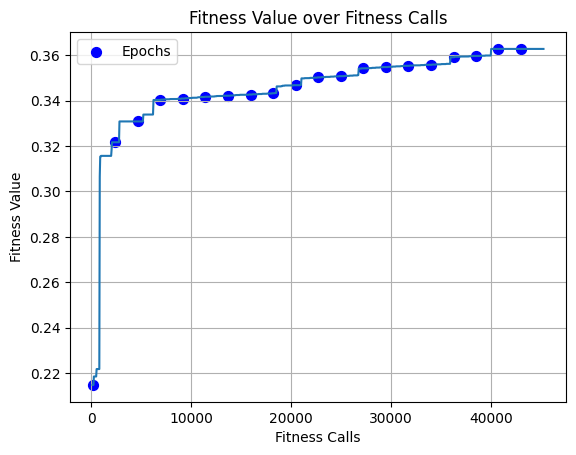

In [7]:
fitness = lab9_lib.make_problem(5)
num_epochs = 20
num_generations = 50
population_size = 100
offset_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05

best, calls, history, calls_history = ea(fitness, population, num_epochs, num_generations, pop_size=population_size,
                  off_size=offset_size, tour_size=2, mut_prob=mutation_probability, xover_prob=0.9, elitism=True, adapt_mut=True)

print(f"BEST FITNESS: {best.fitness}, CALLS: {calls}")
plt.plot(calls_history, history)
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(calls_history)) if i%num_generations == 0]
highlighted_calls = [calls_history[i] for i in best_index_list]
highlighted_values = [history[i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

### Overall

BEST FIT
(FITNESS: 0.46479000000000004, NUM CALLS: 112312, NUM EPOCHS: 50, NUM GENERATIONS: 50, TOURNAMENT SIZE: 3, ADAPTIVE MUTATION: True, ELITISM: True)


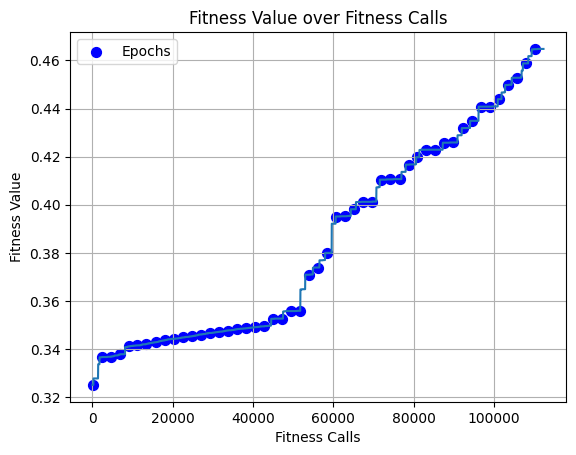

BEST NUM CALLS
(FITNESS: 0.30967, NUM CALLS: 2674, NUM EPOCHS: 20, NUM GENERATIONS: 20, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: True, ELITISM: False)


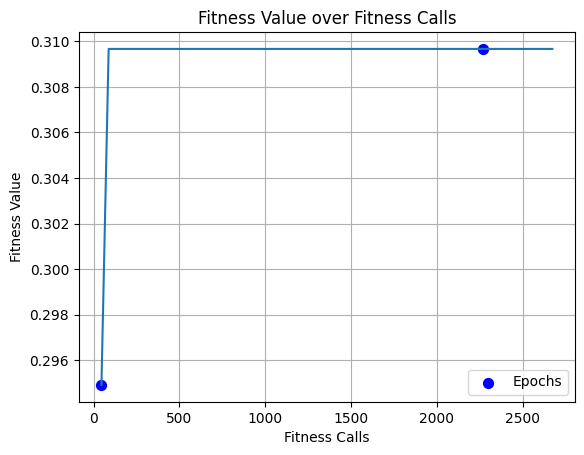

BEST AVERAGE (FIT and NUM CALLS)
(FITNESS: 0.427, NUM CALLS: 12604, NUM EPOCHS: 20, NUM GENERATIONS: 20, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: False, ELITISM: True)


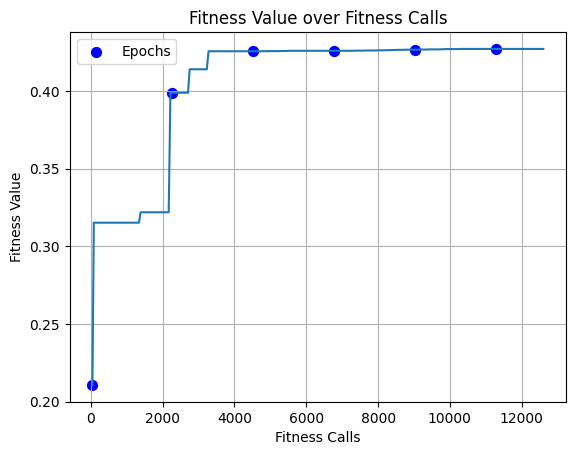

In [8]:
fitness = lab9_lib.make_problem(5)
population_size = 100
offspring_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05
xover_probability = 0.9

num_epochs = [20, 50]
num_generations = [20, 50]
tour_sizes = [2, 3]
elitism = [True, False]
adapt_mut = [True, False]

prev_calls = 0 #USED TO NORMALIZE THE NUMBER OF FUNCTION CALLS FOR EACH ITERATION
results = []
best_fit = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST FITNESS
best_calls = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST NUMBER OF CALLS
best_avg = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST AVERAGE RESULT

for ne in num_epochs:
    for ng in num_generations:
        for t in tour_sizes:
            for e in elitism:
                for a in adapt_mut:
                    best, calls, history, calls_history = ea(fitness, population, num_epochs=ne, num_generations=ng, pop_size=population_size,
                                                            off_size=offspring_size, tour_size=t, mut_prob=mutation_probability,
                                                            xover_prob=xover_probability, adapt_mut=a, elitism=e)
                    
                    norm_calls_history = [x-prev_calls for x in calls_history] #normalized calls_history list
                    results.append([best, calls-prev_calls, ne, ng, t, a, e, history, norm_calls_history])
                    prev_calls = calls

res_fit = [r[0].fitness for r in results]
res_calls = [r[1] for r in results]
avg_fit = sum(res_fit) / len(res_fit)
avg_calls = sum(res_calls) / len(res_calls)

for r in results:
    if not best_fit or r[0].fitness > best_fit[0].fitness or (r[0].fitness == best_fit[0].fitness and r[1] < best_fit[1]):
        best_fit = r
    
    if not best_calls or r[1] < best_calls[1] or (r[1] == best_calls[1] and r[0].fitness > best_fit[0].fitness):
        best_calls = r

    if r[0].fitness >= avg_fit and r[1] <= avg_calls:
        if not best_avg:
            best_avg = r
        else:
            if (r[0].fitness > best_avg[0].fitness and r[1] < best_avg[1]) or (r[0].fitness <= best_avg[0].fitness and r[1] < best_avg[1]):
                best_avg = r

#PLOTTING
print("BEST FIT")
print(f"(FITNESS: {best_fit[0].fitness}, NUM CALLS: {best_fit[1]}, NUM EPOCHS: {best_fit[2]}, NUM GENERATIONS: {best_fit[3]}, TOURNAMENT SIZE: {best_fit[4]}, ADAPTIVE MUTATION: {best_fit[5]}, ELITISM: {best_fit[6]})")
plt.plot(best_fit[8], best_fit[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_fit[7])) if i%ng == 0]
highlighted_calls = [best_fit[8][i] for i in best_index_list]
highlighted_values = [best_fit[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

print("BEST NUM CALLS")
print(f"(FITNESS: {best_calls[0].fitness}, NUM CALLS: {best_calls[1]}, NUM EPOCHS: {best_calls[2]}, NUM GENERATIONS: {best_calls[3]}, TOURNAMENT SIZE: {best_calls[4]}, ADAPTIVE MUTATION: {best_calls[5]}, ELITISM: {best_calls[6]})")
plt.plot(best_calls[8], best_calls[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_calls[7])) if i%ng == 0]
highlighted_calls = [best_calls[8][i] for i in best_index_list]
highlighted_values = [best_calls[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

if best_avg:
    print("BEST AVERAGE (FIT and NUM CALLS)")
    print(f"(FITNESS: {best_avg[0].fitness}, NUM CALLS: {best_avg[1]}, NUM EPOCHS: {best_avg[2]}, NUM GENERATIONS: {best_avg[3]}, TOURNAMENT SIZE: {best_avg[4]}, ADAPTIVE MUTATION: {best_avg[5]}, ELITISM: {best_avg[6]})")
    plt.plot(best_avg[8], best_avg[7])
    plt.title("Fitness Value over Fitness Calls")
    plt.xlabel("Fitness Calls")
    plt.ylabel("Fitness Value")
    plt.grid(True)
    best_index_list = [i for i in range(len(best_avg[7])) if i%ng == 0]
    highlighted_calls = [best_avg[8][i] for i in best_index_list]
    highlighted_values = [best_avg[7][i] for i in best_index_list]
    plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
    plt.legend()
    plt.show()

## 10

### Single Run

BEST FITNESS: 0.42324, CALLS: 45184


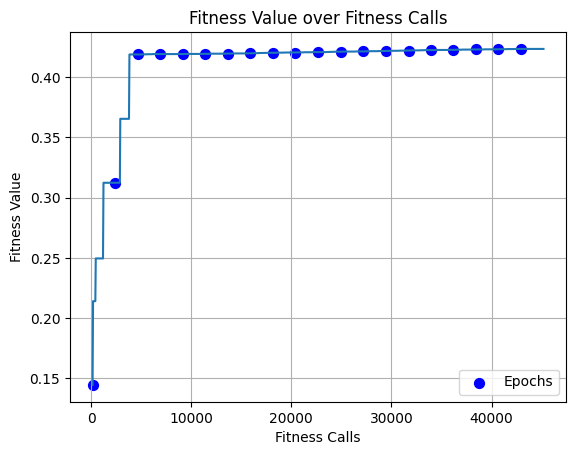

In [9]:
fitness = lab9_lib.make_problem(10)
num_epochs = 20
num_generations = 50
population_size = 100
offset_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05

best, calls, history, calls_history = ea(fitness, population, num_epochs, num_generations, pop_size=population_size,
                  off_size=offset_size, tour_size=2, mut_prob=mutation_probability, xover_prob=0.9, elitism=True, adapt_mut=True)

print(f"BEST FITNESS: {best.fitness}, CALLS: {calls}")
plt.plot(calls_history, history)
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(calls_history)) if i%num_generations == 0]
highlighted_calls = [calls_history[i] for i in best_index_list]
highlighted_values = [history[i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

### Overall

BEST FIT
(FITNESS: 0.372906, NUM CALLS: 9938, NUM EPOCHS: 50, NUM GENERATIONS: 20, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: False, ELITISM: True)


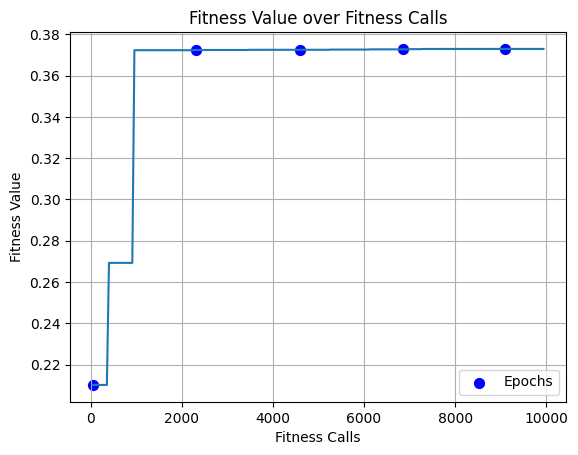

BEST NUM CALLS
(FITNESS: 0.222226796, NUM CALLS: 2656, NUM EPOCHS: 50, NUM GENERATIONS: 20, TOURNAMENT SIZE: 2, ADAPTIVE MUTATION: True, ELITISM: False)


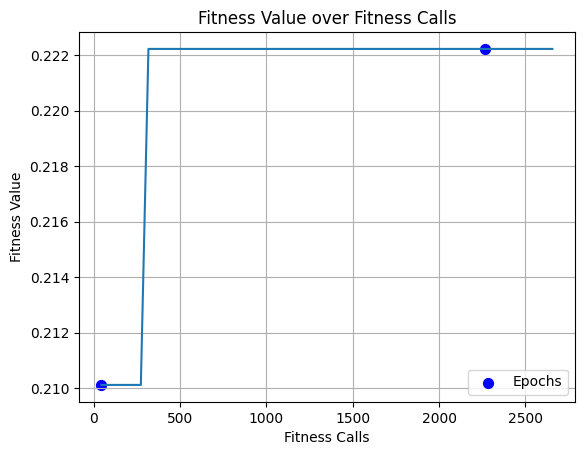

BEST AVERAGE (FIT and NUM CALLS)
(FITNESS: 0.31811239999999996, NUM CALLS: 2698, NUM EPOCHS: 20, NUM GENERATIONS: 20, TOURNAMENT SIZE: 3, ADAPTIVE MUTATION: False, ELITISM: True)


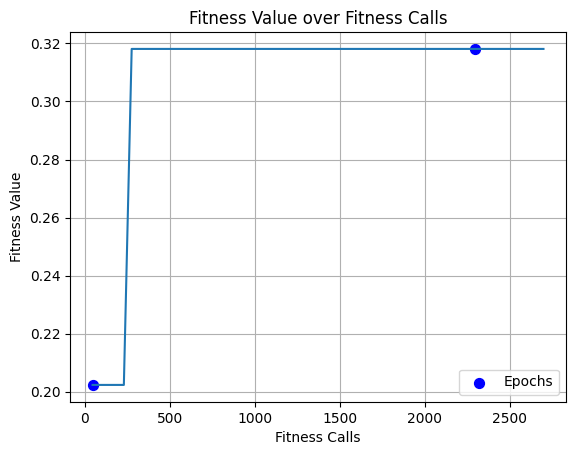

In [10]:
fitness = lab9_lib.make_problem(10)
population_size = 100
offspring_size = 25
population = populate(fitness, population_size)
mutation_probability = 0.05
xover_probability = 0.9

num_epochs = [20, 50]
num_generations = [20, 50]
tour_sizes = [2, 3]
elitism = [True, False]
adapt_mut = [True, False]

prev_calls = 0 #USED TO NORMALIZE THE NUMBER OF FUNCTION CALLS FOR EACH ITERATION
results = []
best_fit = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST FITNESS
best_calls = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST NUMBER OF CALLS
best_avg = [] #KEEPS TRACK OF THE SOLUTION WITH THE BEST AVERAGE RESULT

for ne in num_epochs:
    for ng in num_generations:
        for t in tour_sizes:
            for e in elitism:
                for a in adapt_mut:
                    best, calls, history, calls_history = ea(fitness, population, num_epochs=ne, num_generations=ng, pop_size=population_size,
                                                            off_size=offspring_size, tour_size=t, mut_prob=mutation_probability,
                                                            xover_prob=xover_probability, adapt_mut=a, elitism=e)
                    
                    norm_calls_history = [x-prev_calls for x in calls_history] #normalized calls_history list
                    results.append([best, calls-prev_calls, ne, ng, t, a, e, history, norm_calls_history])
                    prev_calls = calls

res_fit = [r[0].fitness for r in results]
res_calls = [r[1] for r in results]
avg_fit = sum(res_fit) / len(res_fit)
avg_calls = sum(res_calls) / len(res_calls)

for r in results:
    if not best_fit or r[0].fitness > best_fit[0].fitness or (r[0].fitness == best_fit[0].fitness and r[1] < best_fit[1]):
        best_fit = r
    
    if not best_calls or r[1] < best_calls[1] or (r[1] == best_calls[1] and r[0].fitness > best_fit[0].fitness):
        best_calls = r

    if r[0].fitness >= avg_fit and r[1] <= avg_calls:
        if not best_avg:
            best_avg = r
        else:
            if (r[0].fitness > best_avg[0].fitness and r[1] < best_avg[1]) or (r[0].fitness <= best_avg[0].fitness and r[1] < best_avg[1]):
                best_avg = r

#PLOTTING
print("BEST FIT")
print(f"(FITNESS: {best_fit[0].fitness}, NUM CALLS: {best_fit[1]}, NUM EPOCHS: {best_fit[2]}, NUM GENERATIONS: {best_fit[3]}, TOURNAMENT SIZE: {best_fit[4]}, ADAPTIVE MUTATION: {best_fit[5]}, ELITISM: {best_fit[6]})")
plt.plot(best_fit[8], best_fit[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_fit[7])) if i%ng == 0]
highlighted_calls = [best_fit[8][i] for i in best_index_list]
highlighted_values = [best_fit[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

print("BEST NUM CALLS")
print(f"(FITNESS: {best_calls[0].fitness}, NUM CALLS: {best_calls[1]}, NUM EPOCHS: {best_calls[2]}, NUM GENERATIONS: {best_calls[3]}, TOURNAMENT SIZE: {best_calls[4]}, ADAPTIVE MUTATION: {best_calls[5]}, ELITISM: {best_calls[6]})")
plt.plot(best_calls[8], best_calls[7])
plt.title("Fitness Value over Fitness Calls")
plt.xlabel("Fitness Calls")
plt.ylabel("Fitness Value")
plt.grid(True)
best_index_list = [i for i in range(len(best_calls[7])) if i%ng == 0]
highlighted_calls = [best_calls[8][i] for i in best_index_list]
highlighted_values = [best_calls[7][i] for i in best_index_list]
plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
plt.legend()
plt.show()

if best_avg:
    print("BEST AVERAGE (FIT and NUM CALLS)")
    print(f"(FITNESS: {best_avg[0].fitness}, NUM CALLS: {best_avg[1]}, NUM EPOCHS: {best_avg[2]}, NUM GENERATIONS: {best_avg[3]}, TOURNAMENT SIZE: {best_avg[4]}, ADAPTIVE MUTATION: {best_avg[5]}, ELITISM: {best_avg[6]})")
    plt.plot(best_avg[8], best_avg[7])
    plt.title("Fitness Value over Fitness Calls")
    plt.xlabel("Fitness Calls")
    plt.ylabel("Fitness Value")
    plt.grid(True)
    best_index_list = [i for i in range(len(best_avg[7])) if i%ng == 0]
    highlighted_calls = [best_avg[8][i] for i in best_index_list]
    highlighted_values = [best_avg[7][i] for i in best_index_list]
    plt.scatter(highlighted_calls, highlighted_values, color='blue', s=50, label='Epochs')
    plt.legend()
    plt.show()